In [1]:
#Import the necessary libraries
from qiskit import *
from qiskit import BasicAer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_ibm_provider import IBMProvider
from qiskit.providers.aer import AerSimulator

import numpy as np
import matplotlib.pyplot as plt

#Noise Model
from qiskit_ibm_runtime import QiskitRuntimeService

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

# IBM account
#0c36130e3a676af024477eca7ea46d063669eb787b4456993a3b1e22c830d1294d0cc8de85a5f8b5778a6f43c3ec484cac81ec12bddc158b79e95002009efa3e

In [2]:
import qiskit
qiskit.__version__

'0.45.2'

In [3]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

In [4]:
#IBMProvider.save_account('0c36130e3a676af024477eca7ea46d063669eb787b4456993a3b1e22c830d1294d0cc8de85a5f8b5778a6f43c3ec484cac81ec12bddc158b79e95002009efa3e') #save_account('') 

In [5]:
# Vectors used to compute the distance 

vectors= [[[10,6,4,8], [10,6,4,7]],
          [[10,6,4,8], [9,6,4,9] ],
          [[10,6,4,8], [9,6,5,7] ],
          [[10,6,4,8], [8,6,4,6] ],
          [[10,6,4,8], [7,6,5,6] ],
          [[10,6,4,8], [7,5,8,6] ],
          [[10,6,4,8], [5,5,8,6] ],
          [[10,6,4,8], [2,5,12,5]],
          [[12,6,4,8], [2,10,14,5]],
          [[12,18,2,16],[2,7,12,5]],
          [[14,18,2,16],[2,5,12,5]],
          [[16,20,2,17],[4,7,12,1]],
          [[16,20,2,18],[4,5,12,1]],
          [[16,20,2,17],[2,4,15,1]],
          [[18,24,2,19],[5,6,18,1]],
          [[18,24,2,19],[5,6,21,1]],
          [[18,24,2,19],[2,3,21,1]],
         ]

vectors_array = np.array(vectors)

In [44]:
real_distance_list = []
noisy_quantum_distance_list = []
shots = 4000
iteration = 0
runs = 20
qc_list = []
initial_layout=[2,9,16,26,27]

In [45]:
service = QiskitRuntimeService()
backend = service.backend("ibm_kyoto")
noise_model = NoiseModel.from_backend(backend)
basis_gates = noise_model.basis_gates  

In [46]:
sim_vigo = AerSimulator.from_backend(backend)

In [47]:
print(f'Results with an average of {runs} runs and {shots} shots')
print("---------------------------------------------------------------")
print("---------------------------------------------------------------")
for vector in vectors_array:
    A = vector[0]
    B = vector[1]
    
    iteration+=1
    print("Iteration",iteration)
    print("Vectors:")
    print(A)
    print(B)
   
    norm_A = 0 
    norm_B = 0
    Dist = 0
    
    # Compute the classical distance 
    for i in range(len(A)):
        norm_A += A[i]**2
        norm_B += B[i]**2
        Dist += (A[i] - B[i]) ** 2
    
    Dist = np.sqrt(Dist)
    
    A_norm = np.sqrt(norm_A)
    B_norm = np.sqrt(norm_B)
    Z = round((A_norm)**2 + (B_norm)**2)
    #print(Z)
    
    # create phi and psi state with the vector data
    phi = [A_norm/np.sqrt(Z), -B_norm/np.sqrt(Z)]
    psi = []
    for i in range(len(A)):
        psi.append(((A[i]/A_norm) / np.sqrt(2)))
        psi.append(((B[i]/B_norm) / np.sqrt(2)))
        
    # Create circuit 
    q1 = QuantumRegister(1, name = 'q1')
    q2 = QuantumRegister(4, name = 'q2')
    c = ClassicalRegister(1, name = 'c')
    qc = QuantumCircuit(q1,q2,c)

    #States initialization
    qc.initialize(phi, q2[0])
    qc.initialize(psi, q2[1:4])
    
    # The swap test operator
    qc.h(q1[0])
    qc.cswap(q1[0], q2[0], q2[1])
    qc.h(q1[0]) 
    qc.measure(q1,c)
    
    q_distance_list_for_runs = []
    real_distance_list.append(Dist)
    print('Profundidad del circuito transpile',transpile(qc,basis_gates=basis_gates).depth())
    print('Tamaño del circuit transpile', transpile(qc,basis_gates=basis_gates).size())
    #Colocar cuando se executa la lista de circuitos
    for i in range(runs):
    # Perform a noise simulation
           
        tcirc = transpile(qc, sim_vigo)
        
        #transpiled_circuit = transpile(qc, backend_simulator)
    
        #result = backend_simulator.run(transpiled_circuit, shots=shots,optimization_level=3, initial_layout=[0,14,107,117,126]).result()
        #job = execute(qc,Aer.get_backend('qasm_simulator'),shots=shots, noise_model=sim_vigo )
        result = sim_vigo.run(tcirc,shots=shots,optimization_level=3).result() #job.result()
    #qc_list.append(qc)
        counts = result.get_counts(qc)
        x = abs(((counts['0']/shots - 0.5)/0.5) * 2 * Z) #.05
        Q_Dist = round(np.sqrt(x),4)
        q_distance_list_for_runs.append(Q_Dist)
    
    noisy_quantum_distance_list.append(np.array(q_distance_list_for_runs).mean())
    print("Results:")
    print('Noisy Quantum Distance: ', round(np.array(q_distance_list_for_runs).mean(),3))
    print('Euclidean Distance: ',round(Dist,3))
        
    print("---------------------------------------------------------------")
    

Results with an average of 20 runs and 4000 shots
---------------------------------------------------------------
---------------------------------------------------------------
Iteration 1
Vectors:
[10  6  4  8]
[10  6  4  7]
Profundidad del circuito transpile 54
Tamaño del circuit transpile 92
Results:
Noisy Quantum Distance:  4.56
Euclidean Distance:  1.0
---------------------------------------------------------------
Iteration 2
Vectors:
[10  6  4  8]
[9 6 4 9]
Profundidad del circuito transpile 54
Tamaño del circuit transpile 92
Results:
Noisy Quantum Distance:  4.798
Euclidean Distance:  1.414
---------------------------------------------------------------
Iteration 3
Vectors:
[10  6  4  8]
[9 6 5 7]
Profundidad del circuito transpile 54
Tamaño del circuit transpile 92
Results:
Noisy Quantum Distance:  5.111
Euclidean Distance:  1.732
---------------------------------------------------------------
Iteration 4
Vectors:
[10  6  4  8]
[8 6 4 6]
Profundidad del circuito transpile 54


In [48]:
noisy_error_20_run = np.abs(np.array(noisy_quantum_distance_list) -  np.array(real_distance_list))
noisy_error_20_run

array([3.56043   , 3.38380644, 3.37938419, 2.18612288, 1.93505261,
       1.05430442, 0.76263002, 0.34384488, 0.036115  , 0.04065396,
       0.32002002, 0.46907931, 0.5762598 , 0.56080079, 0.79948371,
       0.6418446 , 1.10209059])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


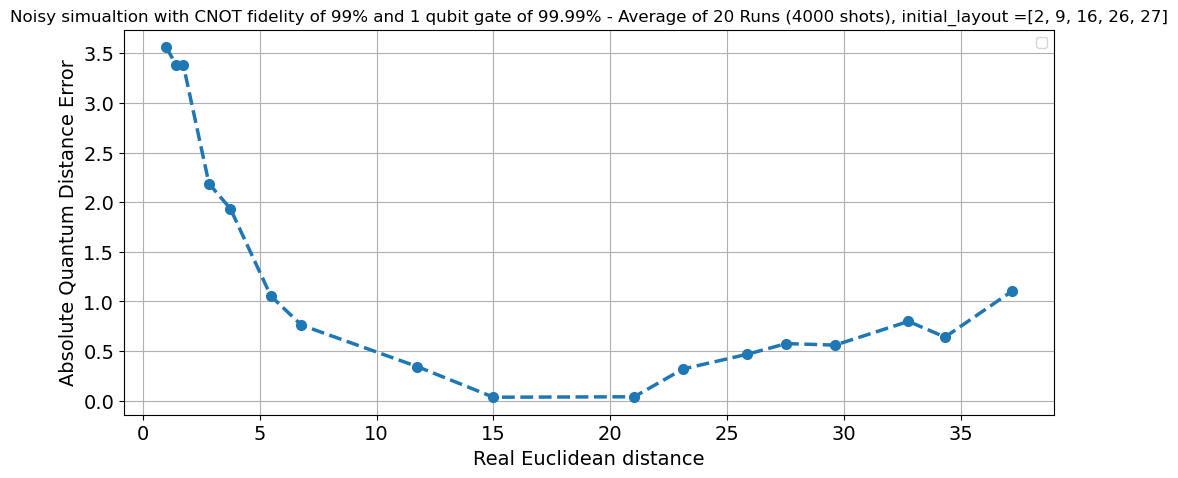

In [49]:
plt.figure(figsize=(12, 5))
plt.plot(np.array(real_distance_list), noisy_error_20_run, "o--", linewidth=2.5, markersize=7)
plt.xticks(size=14)
plt.yticks(size=14)
#plt.xticks(np.arange(99,99.999, step=0.1),size=14)
plt.title(r"Noisy simualtion with CNOT fidelity of 99% and 1 qubit gate of 99.99% - Average of 20 Runs (4000 shots), initial_layout ="+str(initial_layout))
plt.ylabel('Absolute Quantum Distance Error', size= 14)
plt.xlabel('Real Euclidean distance', size=14)
plt.legend()
plt.grid()
plt.show()

/home/miguel/anaconda3/lib/python3.8/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


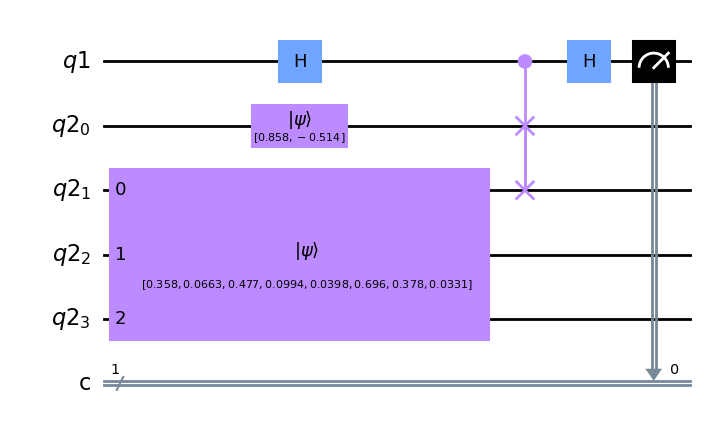

In [34]:
qc.draw(output="mpl")

In [41]:
transpile(qc,basis_gates=basis_gates).depth()

54

In [40]:
transpile(qc,basis_gates=basis_gates).draw()

global phase: 15π/8
      ┌─────────┐  ┌────┐                                                  »
  q1: ┤ Rz(π/2) ├──┤ √X ├──────────────────────────────────────────────────»
      └─────────┘  ├────┤  ┌─────────────┐                                 »
q2_0: ────|0>──────┤ √X ├──┤ Rz(-2.0611) ├─────────────────────────────────»
                 ┌─┴────┴─┐└────┬────┬───┘┌────────────┐                   »
q2_1: ────|0>────┤ Rz(-π) ├─────┤ √X ├────┤ Rz(2.1466) ├───────────────────»
                 ├────────┤     ├────┤    ├────────────┤           ┌──────┐»
q2_2: ────|0>────┤ Rz(-π) ├─────┤ √X ├────┤ Rz(1.7141) ├───────────┤1     ├»
                 └─┬────┬─┘┌────┴────┴───┐└───┬────┬───┘┌─────────┐│  Ecr │»
q2_3: ────|0>──────┤ √X ├──┤ Rz(-1.3078) ├────┤ √X ├────┤ Rz(π/2) ├┤0     ├»
                   └────┘  └─────────────┘    └────┘    └─────────┘└──────┘»
 c: 1/═════════════════════════════════════════════════════════════════════»
                                                                           »
«                                                                          »
«  q1: ────────────────────────────────────────────────────────────────────»
«                                                                          »
«q2_0: ────────────────────────────────────────────────────────────────────»
«                                                                ┌──────┐  »
«q2_1: ──────────────────────────────────────────────────────────┤1     ├──»
«      ┌────────┐   ┌────┐   ┌────────────┐┌──────┐┌──────────┐  │  Ecr │  »
«q2_2: ┤ Rz(-π) ├───┤ √X ├───┤ Rz(2.7103) ├┤1     ├┤ Rz(-π/2) ├──┤0     ├──»
«      └─┬───┬──┘┌──┴────┴──┐└────────────┘│  Ecr │└──┬───┬───┘┌─┴──────┴─┐»
«q2_3: ──┤ X ├───┤ Rz(-π/2) ├──────────────┤0     ├───┤ X ├────┤ Rz(-π/2) ├»
«        └───┘   └──────────┘              └──────┘   └───┘    └──────────┘»
« c: 1/════════════════════════════════════════════════════════════════════»
«                                                                          »
«                                                                        »
«  q1: ──────────────────────────────────────────────────────────────────»
«                                                                        »
«q2_0: ──────────────────────────────────────────────────────────────────»
«      ┌────────┐   ┌────┐   ┌────────────┐┌──────┐┌────────┐   ┌────┐   »
«q2_1: ┤ Rz(-π) ├───┤ √X ├───┤ Rz(2.4396) ├┤1     ├┤ Rz(-π) ├───┤ √X ├───»
«      └─┬───┬──┘┌──┴────┴──┐└────────────┘│      │└────────┘   └────┘   »
«q2_2: ──┤ X ├───┤ Rz(-π/2) ├──────────────┤  Ecr ├──────────────────────»
«        └───┘   └──────────┘              │      │  ┌───┐   ┌──────────┐»
«q2_3: ────────────────────────────────────┤0     ├──┤ X ├───┤ Rz(-π/2) ├»
«                                          └──────┘  └───┘   └──────────┘»
« c: 1/══════════════════════════════════════════════════════════════════»
«                                                                        »
«                                                                    »
«  q1: ──────────────────────────────────────────────────────────────»
«                                                                    »
«q2_0: ──────────────────────────────────────────────────────────────»
«      ┌─────────────┐┌──────┐┌────────┐┌────┐┌─────────────┐┌──────┐»
«q2_1: ┤ Rz(-2.4173) ├┤1     ├┤ Rz(-π) ├┤ √X ├┤ Rz(-2.5353) ├┤1     ├»
«      └─────────────┘│  Ecr │└─┬───┬──┘└────┘└─────────────┘│      │»
«q2_2: ───────────────┤0     ├──┤ X ├────────────────────────┤  Ecr ├»
«                     └──────┘  └───┘                        │      │»
«q2_3: ──────────────────────────────────────────────────────┤0     ├»
«                                                            └──────┘»
« c: 1/══════════════════════════════════════════════════════════════»
«                                                                    »
«                                                                            »
«

In [42]:
transpile(qc,basis_gates=basis_gates,optimization_level=3).size()

92